In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import date, timedelta

In [2]:
symbols = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0] # This is S&P500
symbols = symbols.Symbol.to_list()  

#symbols = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4] # this is NASDAQ
#symbols = symbols.Ticker.to_list()  

In [3]:
start_date = '2010-01-01'

In [4]:
data = yf.download(symbols,start=start_date)['Adj Close']

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [5]:
df = data.copy()
df.index = pd.to_datetime(df.index)

## <center>Format Data</center>

In [6]:
mtl = (df.pct_change() + 1)[1:].resample('M').prod()
mtl.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-31,0.895527,1.113208,0.976969,0.897435,1.0,1.023657,0.979189,0.994302,0.974328,0.870855,...,0.967480,0.985769,0.931742,0.949052,1.0,0.980644,0.938354,0.910359,1.423106,1.0
2010-02-28,1.122369,1.380414,1.034220,1.065396,1.0,1.031652,1.025312,1.034107,0.975116,1.072755,...,1.027311,1.001443,1.015428,0.986877,1.0,0.985676,1.017934,1.094636,0.977876,1.0
2010-03-31,1.093134,1.002729,1.028856,1.148471,1.0,1.031384,0.970523,1.030684,1.049537,1.020779,...,1.192858,1.030484,1.030462,1.055621,1.0,1.136714,1.032618,1.036052,1.177994,1.0
2010-04-30,1.054376,0.961905,1.075858,1.111021,1.0,1.066736,0.979328,0.991213,1.049417,0.949958,...,1.163655,1.025943,1.011795,1.050746,1.0,1.112380,1.028886,0.981419,1.315476,1.0
2010-05-31,0.892443,1.248940,1.147672,0.983875,1.0,1.016526,0.929632,0.972744,0.859762,0.954762,...,0.953687,0.942069,0.898194,0.884856,1.0,0.965347,0.918240,0.946644,0.833923,1.0


---

## <center>Strategy</center>

In [7]:
def get_rolling_ret(df,n):
    return df.rolling(n).apply(np.prod)

In [8]:
ret_12, ret_6, ret_3 = get_rolling_ret(mtl,12), get_rolling_ret(mtl,6), get_rolling_ret(mtl,3)

In [9]:
def get_top(date):
    top_50 = ret_12.loc[date].nlargest(50).index
    top_30 = ret_6.loc[date, top_50].nlargest(30).index
    top_10 = ret_3.loc[date, top_30].nlargest(10).index
    return(top_10)

---

### Get top function for picks of the month (i.e month before)

In [10]:
today = date.today()
days = int(today.strftime("%d"))
days = timedelta(days)

last_month = today - days
last_month = last_month.strftime("%Y-%m-%d")

In [11]:
list(get_top(last_month))

['GE', 'FSLR', 'GEHC', 'ANET', 'WYNN', 'ON', 'CDNS', 'PHM', 'GWW', 'BWA']

---

In [12]:
portfolio = mtl.loc['2010-12-31':, get_top('2010-12-31')][1:2]

In [13]:
def performance(date):
    portfolio = mtl.loc[date:,get_top(date)][1:2]
    return portfolio.mean(axis=1).values[0] 

In [14]:
performance('2010-12-31') 

1.0303227766688152

## <center>Calculate Performance and Compare</center>

In [15]:
returns = []

for date in mtl.index[:-1]:
    returns.append(performance(date))

<Axes: xlabel='Date'>

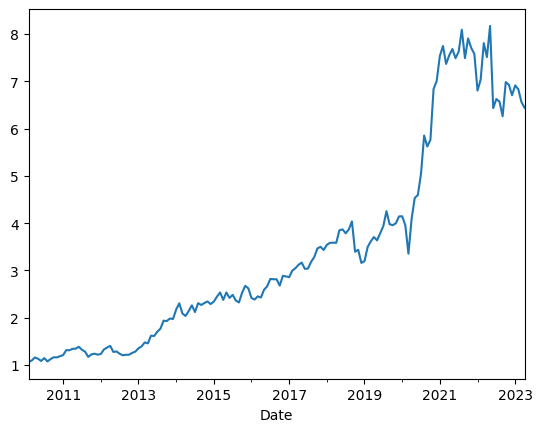

In [16]:
returns = pd.Series([i - 0.01 for i in returns], index=mtl.index[1:]).cumprod()
returns.plot()

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

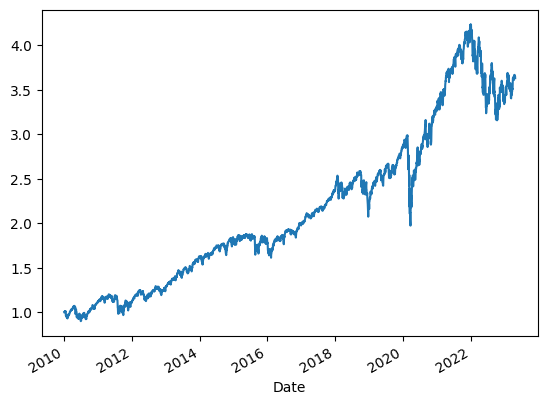

In [17]:
sp = yf.download('^GSPC',start=start_date)['Adj Close']

sp = (sp.pct_change() + 1).cumprod()[1:]
sp.plot()

In [18]:
"%.2f" % sp[-1]
# S&P500 returns

'3.63'

In [19]:
"%.2f" % returns[-1]
# Strategy returns

'6.44'

---

- Keep in mind survivorship bias, we cannot say for certain that this will continue
    - What about stocks that have gone under?
    - We're overlooking poor stocks, only the upwards general trend

[YouTube walkthrough](https://www.youtube.com/watch?v=bUejGzheCac)